# Part 2: Segmentation with Clustering

In [2]:
import datetime
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

For this tutorial, we are going to create several clustering algorithms and, most importantly, analyze and interpret the result. We are going to use cleaned and preprocessed data from our first class. However, the data is not yet fully ready for use. We need to convert it to a customer level dataset.

In [3]:
# Load the data
data = pd.read_csv('data/data_cleared.csv')

data['InvoiceNo'] = data['InvoiceNo'].astype('O')
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data.head()

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,OrderHour,OrderMonth,OrderWeekday
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,8,12,2
1,1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,8,12,2
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,8,12,2
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,8,12,2
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,8,12,2


For the first model, we are going to create an RFM table as we did [in the previous lesson.](https://github.com/Tigran-Karamyan/customer_behaviour/blob/master/Week_6_Basics_of_Segmentation_RFM.ipynb) 

In [4]:
# create RFM
dt = data.groupby(['CustomerID', 'InvoiceDate'], as_index=False)['TotalPrice'].sum()
dt.head()

,CustomerID,InvoiceDate,TotalPrice
0,12347.0,2010-12-07 14:57:00,711.79
1,12347.0,2011-01-26 14:30:00,475.39
2,12347.0,2011-04-07 10:43:00,636.25
3,12347.0,2011-06-09 13:01:00,382.52
4,12347.0,2011-08-02 08:48:00,584.91


In [5]:
now = datetime.datetime(2011,12,10)

rfm= dt.groupby('CustomerID').agg({'InvoiceDate': lambda date: (now - date.max()).days,
                                     'CustomerID': 'count',
                                     'TotalPrice': 'mean'})

rfm.columns=['recency', 'frequency', 'monetary',]
rfm.reset_index(inplace=True)
rfm.head()

,CustomerID,recency,frequency,monetary
0,12347.0,2,7,615.714286
1,12348.0,75,4,359.310000
2,12349.0,18,1,1457.550000
3,12350.0,310,1,294.400000
4,12352.0,36,7,197.962857


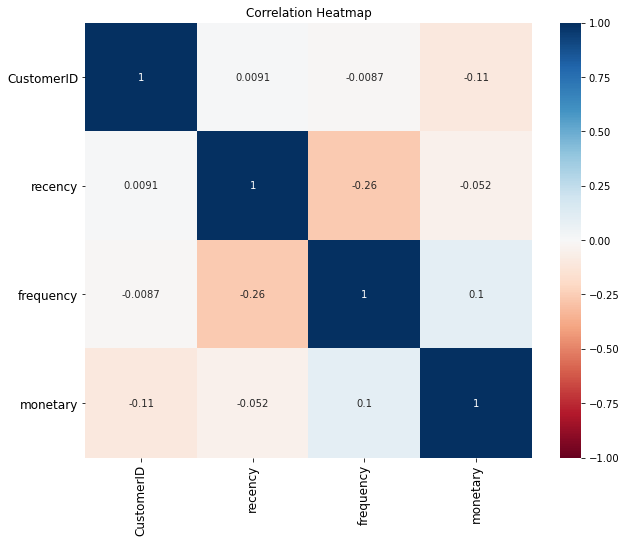

In [6]:
# Compute Pearson correlation coefficient for the features in our data set.
plt.figure(figsize = (10, 8))
s = sns.heatmap(rfm.corr(),
               annot = True, 
               cmap = 'RdBu',
               vmin = -1, 
               vmax = 1)

s.set_yticklabels(s.get_yticklabels(), rotation = 0, fontsize = 12)
s.set_xticklabels(s.get_xticklabels(), rotation = 90, fontsize = 12)
plt.title('Correlation Heatmap')
plt.show()

In [7]:
# Standardizing data
cluster_data = rfm.drop(columns='CustomerID')
scaler = StandardScaler()
data_stand = scaler.fit_transform(cluster_data)

In [17]:
cluster_data

,recency,frequency,monetary
0,2,7,615.714286
1,75,4,359.310000
2,18,1,1457.550000
3,310,1,294.400000
4,36,7,197.962857
...,...,...,...
4329,277,1,180.600000
4330,180,1,80.820000
4331,7,2,89.025000
4332,3,16,130.558125


In [9]:
# data_stand * std(cluster_data) + mean(cluster_data)

## ${\textbf{Hierarchical Clustering}}$

Hierarchical clustering starts by treating each observation as a separate cluster. Then, it repeatedly executes the following two steps: 
1. identify the two clusters that are closest together 
2. merge the two most similar clusters. This iterative process continues until all the clusters are merged together

The main output of Hierarchical Clustering is a dendrogram, which shows the hierarchical relationship between the clusters.

[Ward Method](https://jbhender.github.io/Stats506/F18/GP/Group10.html)

In [11]:
hier_clust = linkage(data_stand, method = 'ward')

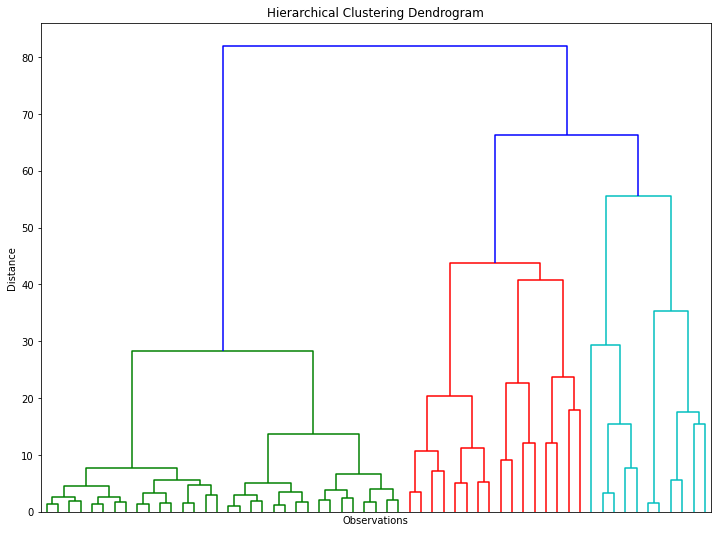

In [13]:
# We plot the results from the Hierarchical Clustering using a Dendrogram. 
plt.figure(figsize = (12,9))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Observations')
plt.ylabel('Distance')
dendrogram(hier_clust,
           truncate_mode = 'level', 
           p = 5,
           no_labels = True)
plt.show()

The dendrogram shows that we have 3 different clusters. However, hierarchical clustering is not the most popular and advanced segmentation method. Anyway, it can help us get some preliminary insight about our data and customers, as well as we will get more understanding about how to use other machine learning algorithms such as K-Means.

## ${\textbf{K-means Clustering}}$

To process the learning data, the K-means algorithm in data mining starts with a first group of randomly selected centroids, which are used as the beginning points for every cluster, and then performs iterative (repetitive) calculations to optimize the positions of the centroids. 

[About Silhouette Score](https://towardsdatascience.com/silhouette-coefficient-validating-clustering-techniques-e976bb81d10c#:~:text=Silhouette%20Coefficient%20or%20silhouette%20score%20is%20a%20metric%20used%20to,each%20other%20and%20clearly%20distinguished.)

In [30]:
# Loop and count Within Cluster Sum of Squares
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters = i,  random_state = 42)
    kmeans.fit(data_stand)
    wcss.append(kmeans.inertia_)

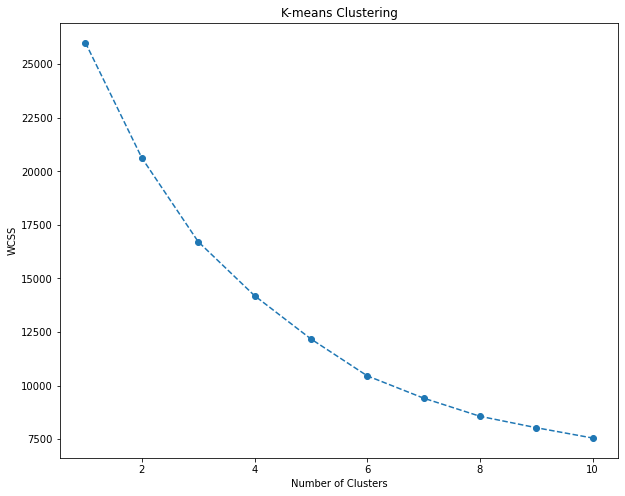

In [31]:
plt.figure(figsize = (10,8))
plt.plot(range(1, 11), wcss, marker = 'o', linestyle = '--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-means Clustering')
plt.show()

In [32]:
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
kmeans.fit(data_stand)

KMeans(n_clusters=4, random_state=42)

Using the Elbow method, we see that we can distinguish 4 clusters. Now let's interpret the results.

### ${\textbf{Results}}$

In [33]:
segm_labels = cluster_data.copy()
segm_labels['Segments'] = kmeans.labels_
segm_labels.head()

,recency,frequency,monetary,Segments
0,2,7,615.714286,3
1,75,4,359.310000,3
2,18,1,1457.550000,0
3,310,1,294.400000,1
4,36,7,197.962857,3


In [34]:
profiling = segm_labels.groupby(['Segments'], as_index=False).mean()
profiling

,Segments,recency,frequency,monetary
0,0,54.885275,2.019515,372.633482
1,1,252.045726,1.528827,275.961156
2,2,79.868421,9.947368,3775.311046
3,3,31.459662,8.124453,366.860998


In [35]:
#Create new columns: Segment size and Segment proportion 
profiling['Segment_size'] = segm_labels.groupby(['Segments'])['Segments'].count()
profiling['Segment_prop'] = round(profiling['Segment_size'] / profiling['Segment_size'].sum() * 100, 2)

# Add the segment labels to our table
profiling['Segments'] = profiling['Segments'].map({0:'promising', 
                                                   1:'champions',
                                                   2:'lost', 
                                                   3:'high spenders'})

profiling

,Segments,recency,frequency,monetary,Segment_size,Segment_prop
0,promising,54.885275,2.019515,372.633482,1691,39.02
1,champions,252.045726,1.528827,275.961156,1006,23.21
2,lost,79.868421,9.947368,3775.311046,38,0.88
3,high spenders,31.459662,8.124453,366.860998,1599,36.89


In [36]:
segm_labels['Segments'] = segm_labels['Segments'].map({0:'promising', 
                                                   1:'champions',
                                                   2:'lost', 
                                                   3:'high spenders'})

segm_labels.head()

,recency,frequency,monetary,Segments
0,2,7,615.714286,high spenders
1,75,4,359.310000,high spenders
2,18,1,1457.550000,promising
3,310,1,294.400000,champions
4,36,7,197.962857,high spenders


C:\Users\tkaramyan\Anaconda3.1\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


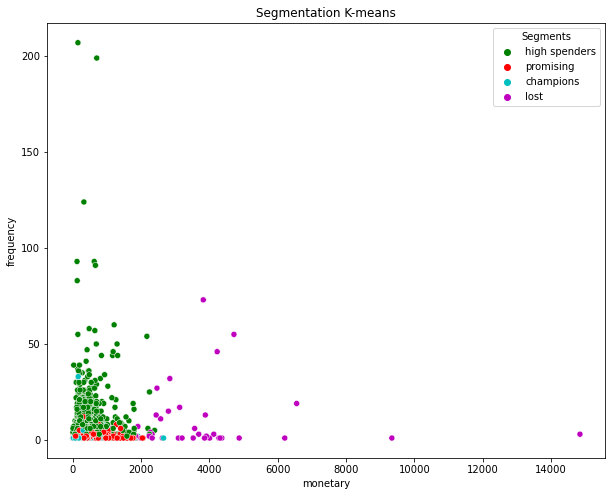

In [37]:
x_axis = segm_labels['monetary']
y_axis = segm_labels['frequency']
plt.figure(figsize = (10, 8))
sns.scatterplot(x_axis, y_axis, hue = segm_labels['Segments'], palette = ['g', 'r', 'c', 'm'])
plt.title('Segmentation K-means')
plt.show()

C:\Users\tkaramyan\Anaconda3.1\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


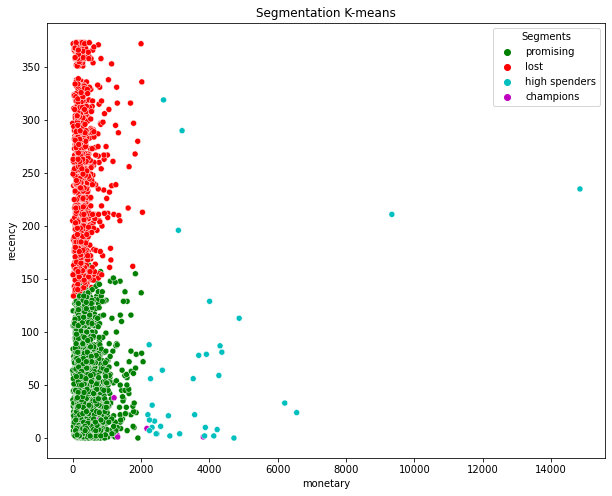

In [25]:
x_axis = segm_labels['monetary']
y_axis = segm_labels['recency']
plt.figure(figsize = (10, 8))
sns.scatterplot(x_axis, y_axis, hue = segm_labels['Segments'], palette = ['g', 'r', 'c', 'm'])
plt.title('Segmentation K-means')
plt.show()

C:\Users\tkaramyan\Anaconda3.1\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


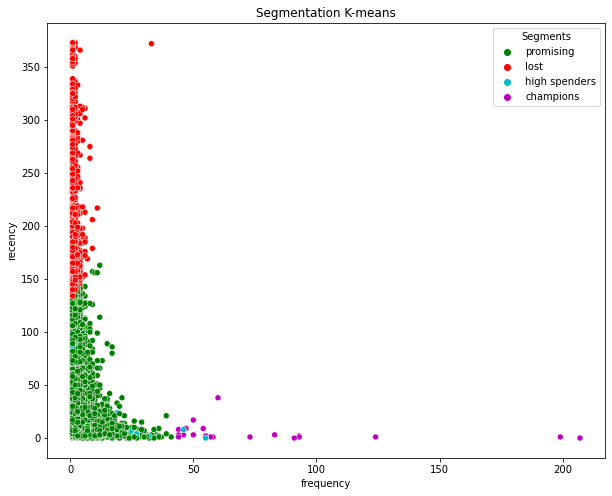

In [26]:
x_axis = segm_labels['frequency']
y_axis = segm_labels['recency']
plt.figure(figsize = (10, 8))
sns.scatterplot(x_axis, y_axis, hue = segm_labels['Segments'], palette = ['g', 'r', 'c', 'm'])
plt.title('Segmentation K-means')
plt.show()

# Add more features

Now let's add some more features and see if the results are changing.

In [27]:
dt = data.groupby(['CustomerID', 'InvoiceDate'], as_index=False).agg({'TotalPrice': 'sum', 
                                                                      'Quantity' : 'sum', 
                                                                      "InvoiceNo" : 'count'})

customer_data = dt.groupby(['CustomerID']).agg(AvgQuantity = ('Quantity', 'mean'), 
                                               AvgDifferentProducts = ('InvoiceNo', 'mean'),
                                               Recency = ('InvoiceDate', lambda date: (now - date.max()).days),
                                               Frequency = ('CustomerID', 'count'),
                                               Monetary_Value = ('TotalPrice', 'mean'),
                                               GapBetweenOrders = ('InvoiceDate', lambda date: (date.max() - date.min()).days)
                                              )

customer_data.head()

,AvgQuantity,AvgDifferentProducts,Recency,Frequency,Monetary_Value,GapBetweenOrders
CustomerID,,,,,,
12347.0,351.142857,26.00,2,7,615.714286,365
12348.0,583.000000,6.75,75,4,359.310000,282
12349.0,630.000000,72.00,18,1,1457.550000,0
12350.0,196.000000,16.00,310,1,294.400000,0
12352.0,75.142857,11.00,36,7,197.962857,260


In [28]:
data_stand = scaler.fit_transform(customer_data)

wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters = i, random_state = 42)
    kmeans.fit(data_stand)
    wcss.append(kmeans.inertia_)

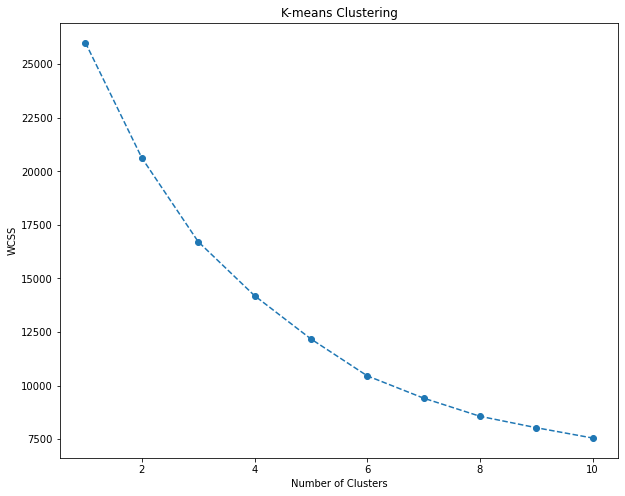

In [29]:
plt.figure(figsize = (10,8))
plt.plot(range(1, 11), wcss, marker = 'o', linestyle = '--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-means Clustering')
plt.show()

In [38]:
kmeans = KMeans(n_clusters = 3,  random_state = 42)
kmeans.fit(data_stand)

KMeans(n_clusters=3, random_state=42)

In [39]:
segm_labels = customer_data.copy()
segm_labels['Segments'] = kmeans.labels_
segm_labels.head()

,AvgQuantity,AvgDifferentProducts,Recency,Frequency,Monetary_Value,GapBetweenOrders,Segments
CustomerID,,,,,,,
12347.0,351.142857,26.00,2,7,615.714286,365,1
12348.0,583.000000,6.75,75,4,359.310000,282,1
12349.0,630.000000,72.00,18,1,1457.550000,0,0
12350.0,196.000000,16.00,310,1,294.400000,0,0
12352.0,75.142857,11.00,36,7,197.962857,260,1


In [40]:
profiling = segm_labels.groupby(['Segments'], as_index=False).mean()

profiling['Segment_size'] = segm_labels.groupby(['Segments'])['Segments'].count()
profiling['Segment_prop'] = round(profiling['Segment_size'] / profiling['Segment_size'].sum() * 100, 2)

profiling

,Segments,AvgQuantity,AvgDifferentProducts,Recency,Frequency,Monetary_Value,GapBetweenOrders,Segment_size,Segment_prop
0,0,194.725833,21.381267,138.584975,1.662972,323.116835,27.570197,2436,56.21
1,1,231.898194,22.745166,31.763441,7.469355,380.235626,264.508602,1860,42.92
2,2,2421.629479,61.094889,79.868421,9.947368,3775.311046,146.421053,38,0.88


In [41]:
# Add the segment labels to our table
profiling['Segments'] = profiling['Segments'].map({0:'lost', 
                                                   1:'promising',
                                                   2:'champions'})

profiling

,Segments,AvgQuantity,AvgDifferentProducts,Recency,Frequency,Monetary_Value,GapBetweenOrders,Segment_size,Segment_prop
0,lost,194.725833,21.381267,138.584975,1.662972,323.116835,27.570197,2436,56.21
1,promising,231.898194,22.745166,31.763441,7.469355,380.235626,264.508602,1860,42.92
2,champions,2421.629479,61.094889,79.868421,9.947368,3775.311046,146.421053,38,0.88


In [42]:
segm_labels['Segments'] = segm_labels['Segments'].map({0:'lost', 
                                                   1:'promising',
                                                   2:'champions'})

segm_labels.head()

,AvgQuantity,AvgDifferentProducts,Recency,Frequency,Monetary_Value,GapBetweenOrders,Segments
CustomerID,,,,,,,
12347.0,351.142857,26.00,2,7,615.714286,365,promising
12348.0,583.000000,6.75,75,4,359.310000,282,promising
12349.0,630.000000,72.00,18,1,1457.550000,0,lost
12350.0,196.000000,16.00,310,1,294.400000,0,lost
12352.0,75.142857,11.00,36,7,197.962857,260,promising


C:\Users\tkaramyan\Anaconda3.1\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


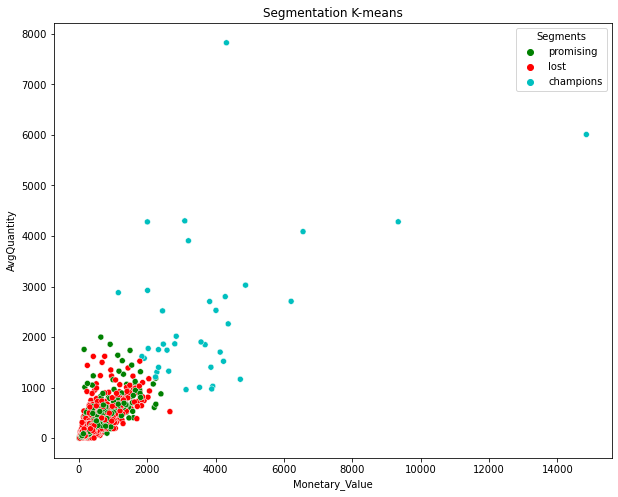

In [43]:
x_axis = segm_labels['Monetary_Value']
y_axis = segm_labels['AvgQuantity']
plt.figure(figsize = (10, 8))
sns.scatterplot(x_axis, y_axis, hue = segm_labels['Segments'], palette = ['g', 'r', 'c'])
plt.title('Segmentation K-means')
plt.show()

C:\Users\tkaramyan\Anaconda3.1\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


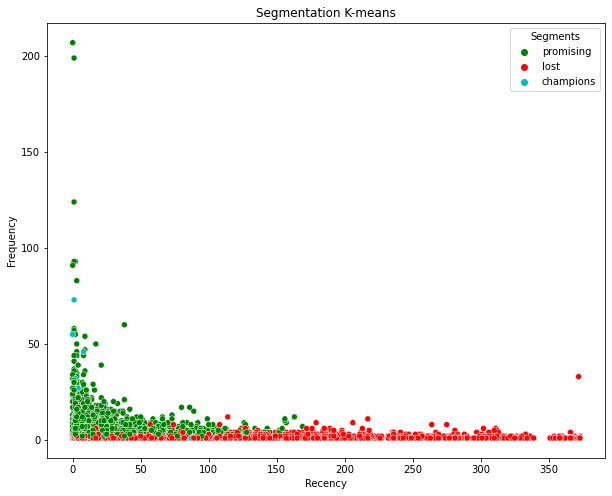

In [44]:
x_axis = segm_labels['Recency']
y_axis = segm_labels['Frequency']
plt.figure(figsize = (10, 8))
sns.scatterplot(x_axis, y_axis, hue = segm_labels['Segments'], palette = ['g', 'r', 'c'])
plt.title('Segmentation K-means')
plt.show()

C:\Users\tkaramyan\Anaconda3.1\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


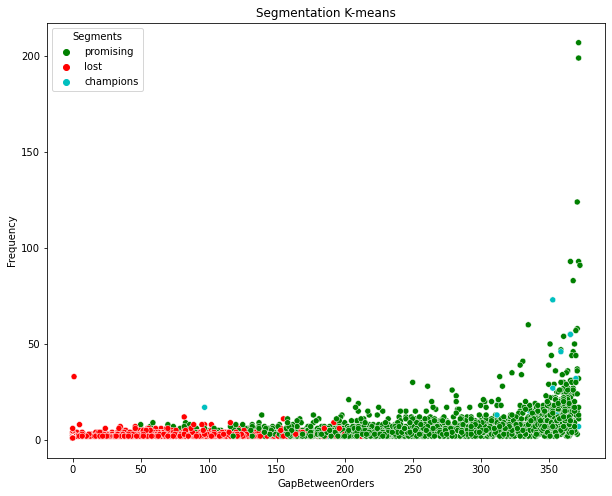

In [45]:
x_axis = segm_labels['GapBetweenOrders']
y_axis = segm_labels['Frequency']
plt.figure(figsize = (10, 8))
sns.scatterplot(x_axis, y_axis, hue = segm_labels['Segments'], palette = ['g', 'r', 'c'])
plt.title('Segmentation K-means')
plt.show()


### ${\textbf{PCA}}$ + Scrapping

Principal Component Analysis, or PCA, is a dimensionality-reduction method that is often used to reduce the dimensionality of large data sets, by transforming a large set of variables into a smaller one that still contains most of the information in the large set. 

In [ ]:
pca = PCA()
pca.fit(data_stand)
pca.explained_variance_ratio_

In [ ]:
plt.figure(figsize = (12,9))
plt.plot(range(1,7), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

According to the rule of thumb, 80% explained variance is a good choice for PCA.

In [ ]:
pca = PCA(n_components = 3)
pca.fit(data_stand)

### ${\textbf{PCA Results}}$

In [ ]:
df_pca_comp = pd.DataFrame(data = pca.components_,
                           columns = customer_data.columns.values,
                           index = ['Component 1', 'Component 2', 'Component 3'])
df_pca_comp

In [ ]:
sns.heatmap(df_pca_comp,
            vmin = -1, 
            vmax = 1,
            cmap = 'RdBu',
            annot = True)
plt.yticks([0, 1, 2], 
           ['Component 1', 'Component 2', 'Component 3'],
           rotation = 45,
           fontsize = 9)

In [ ]:
pca_results = pca.transform(data_stand)

### ${\textbf{K-means clustering with PCA}}$

In [ ]:
# We fit K means using the transformed data from the PCA.
wcss = []
for i in range(1,11):
    kmeans_pca = KMeans(n_clusters = i, random_state = 42)
    kmeans_pca.fit(pca_results)
    wcss.append(kmeans_pca.inertia_)

In [ ]:
# Plot the Within Cluster Sum of Squares for the K-means PCA model. Here we make a decission about the number of clusters.
# Again it looks like four is the best option.
plt.figure(figsize = (10,8))
plt.plot(range(1, 11), wcss, marker = 'o', linestyle = '--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-means with PCA Clustering')
plt.show()

In [ ]:
kmeans_pca = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
kmeans_pca.fit(pca_results)

In [ ]:
pca_frame = pd.DataFrame(pca_results, columns=['Component 1', 'Component 2', 'Component 3'])
final_data = pd.concat([customer_data.reset_index(drop = True), pca_frame],  axis = 1)
final_data['Segments'] = kmeans_pca.labels_

In [ ]:
segm_labels = customer_data.copy()
segm_labels['Segments'] = kmeans.labels_
segm_labels.head()

In [ ]:
profiling = final_data.groupby(['Segments'], as_index=False).mean()

profiling['Segment_size'] = final_data.groupby(['Segments'])['Segments'].count()
profiling['Segment_prop'] = round(profiling['Segment_size'] / profiling['Segment_size'].sum() * 100, 2)

profiling

In [ ]:
# Add the segment labels to our table
profiling['Segments'] = profiling['Segments'].map({0:'new_and_promising', 
                                                   1:'lost',
                                                   2:'promising', 
                                                   3:'champions'})

profiling

In [ ]:
# Add the segment labels to our table
final_data['Segments'] = final_data['Segments'].map({0:'new_and_promising', 
                                                   1:'lost',
                                                   2:'promising', 
                                                   3:'champions'})

final_data.head()

In [ ]:
x_axis = final_data['Component 2']
y_axis = final_data['Component 1']
plt.figure(figsize = (10, 8))
sns.scatterplot(x_axis, y_axis, hue = final_data['Segments'], palette = ['g', 'r', 'c', 'm'])
plt.title('Clusters by PCA Components')
plt.show()

As we can see, PCA helps to get better quality segments with clearer differences. We can now use these segments to create a better business strategy or make more personalized decisions.